# Chapter 4: SHAP-Based Clustering Analysis

**Research Question**: *"Are there distinct 'archetypes' of firms based on how the model assigns risk, and do these archetypes have meaningfully different default rates?"*

## Motivation:
Previous chapters showed that LightGBM uses 40 features with significant interactions to predict default risk. This chapter investigates whether firms cluster into interpretable groups based on their SHAP value patterns - i.e., groups that are scored similarly by the model.

## Objectives:
1. Cluster firms based on SHAP value patterns (not raw features)
2. Characterize each cluster's risk profile
3. Compute actual default rates per cluster
4. Identify whether distinct "failure modes" or "safety profiles" exist

## Key Insight:
By clustering on SHAP values rather than raw features, we group firms by **how the model perceives them**, not by their objective characteristics. Two firms with very different financials might cluster together if the model assigns them similar risk contributions.

---

In [59]:
import sys
from pathlib import Path
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# UMAP for 2D visualization
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    print("⚠ umap-learn not installed. Run: pip install umap-learn")
    print("  Will use PCA for 2D visualization instead.")
    UMAP_AVAILABLE = False

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Project root: {PROJ_ROOT}")
print(f"UMAP available: {UMAP_AVAILABLE}")

Project root: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis
UMAP available: True


## 1. Load SHAP Cache and Data

In [60]:
# Load SHAP cache from Chapter 1
cache_file = PROJ_ROOT / "results" / "xai_exploration" / "shap_cache.pkl"

print(f"Loading SHAP cache from: {cache_file}")
with open(cache_file, 'rb') as f:
    shap_cache = pickle.load(f)

# Extract data
X_val = shap_cache['X_val']
y_val = shap_cache['y_val']
y_pred_lgbm = shap_cache['y_pred_proba_lgbm']
y_pred_logit = shap_cache['y_pred_proba_logit']
shap_values_lgbm = shap_cache['shap_values_lgbm']
feature_names = shap_cache['feature_names']

print(f"\n✓ Loaded validation set:")
print(f"  • Observations: {len(X_val):,}")
print(f"  • Features: {len(feature_names)}")
print(f"  • SHAP values shape: {shap_values_lgbm.shape}")
print(f"  • Defaults: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"  • Non-defaults: {(~y_val.astype(bool)).sum():,}")

Loading SHAP cache from: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_exploration/shap_cache.pkl

✓ Loaded validation set:
  • Observations: 60,830
  • Features: 29
  • SHAP values shape: (60830, 29)
  • Defaults: 1,071 (1.76%)
  • Non-defaults: 59,759


## 2. Preprocessing for Clustering

Steps:
1. **Standardize SHAP values** - Scale to unit variance (already centered at ~0)
2. **PCA** - Reduce dimensionality while preserving 95% variance
3. **UMAP** - Create 2D embedding for visualization

In [61]:
# Step 1: Standardize SHAP values
print("Preprocessing SHAP values for clustering...")
print("="*60)

scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_values_lgbm)

print(f"\n1. Standardization:")
print(f"   Original SHAP range: [{shap_values_lgbm.min():.3f}, {shap_values_lgbm.max():.3f}]")
print(f"   Scaled SHAP range: [{shap_scaled.min():.3f}, {shap_scaled.max():.3f}]")
print(f"   Scaled mean: {shap_scaled.mean():.6f} (should be ~0)")
print(f"   Scaled std: {shap_scaled.std():.6f} (should be ~1)")

Preprocessing SHAP values for clustering...

1. Standardization:
   Original SHAP range: [-1.806, 1.679]
   Scaled SHAP range: [-14.478, 32.574]
   Scaled mean: 0.000000 (should be ~0)
   Scaled std: 1.000000 (should be ~1)



2. PCA Dimensionality Reduction:
   Original dimensions: 29
   Reduced dimensions: 25
   Variance explained: 96.0%


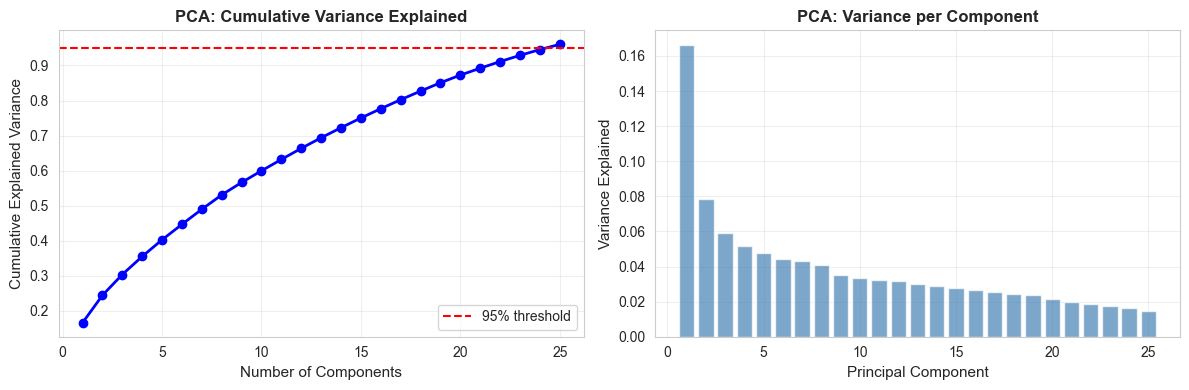


   Top 5 components explain: 40.3% of variance


In [62]:
# Step 2: PCA for dimensionality reduction
print("\n2. PCA Dimensionality Reduction:")

# Fit PCA to capture 95% variance
pca = PCA(n_components=0.95, random_state=42)
shap_pca = pca.fit_transform(shap_scaled)

print(f"   Original dimensions: {shap_scaled.shape[1]}")
print(f"   Reduced dimensions: {shap_pca.shape[1]}")
print(f"   Variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Cumulative variance
cumvar = np.cumsum(pca.explained_variance_ratio_)
axes[0].plot(range(1, len(cumvar)+1), cumvar, 'bo-', linewidth=2, markersize=6)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[0].set_xlabel('Number of Components', fontsize=11)
axes[0].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[0].set_title('PCA: Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Individual variance
axes[1].bar(range(1, len(pca.explained_variance_ratio_)+1), 
            pca.explained_variance_ratio_, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Principal Component', fontsize=11)
axes[1].set_ylabel('Variance Explained', fontsize=11)
axes[1].set_title('PCA: Variance per Component', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n   Top 5 components explain: {cumvar[4]*100:.1f}% of variance")

In [63]:
# Step 3: UMAP for 2D visualization
print("\n3. UMAP 2D Embedding for Visualization:")

if UMAP_AVAILABLE:
    start_time = time.time()
    reducer = umap.UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=15, 
        min_dist=0.1,
        metric='euclidean'
    )
    # Use PCA-reduced data for speed
    shap_2d = reducer.fit_transform(shap_pca)
    elapsed = time.time() - start_time
    print(f"   ✓ UMAP completed in {elapsed:.1f}s")
    print(f"   2D embedding shape: {shap_2d.shape}")
else:
    # Fallback to PCA 2D
    pca_2d = PCA(n_components=2, random_state=42)
    shap_2d = pca_2d.fit_transform(shap_scaled)
    print(f"   ✓ Using PCA 2D instead (UMAP not available)")
    print(f"   2D embedding shape: {shap_2d.shape}")

print("\n" + "="*60)
print("Preprocessing complete!")
print("="*60)


3. UMAP 2D Embedding for Visualization:


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


   ✓ UMAP completed in 20.2s
   2D embedding shape: (60830, 2)

Preprocessing complete!


## 3. Determine Optimal Number of Clusters

We test k=2 to 10 and evaluate using:
- **Elbow method**: Inertia (within-cluster sum of squares)
- **Silhouette score**: Measure of cluster cohesion and separation
- **Davies-Bouldin index**: Ratio of within-cluster to between-cluster distances

In [64]:
# Test different values of k
K_range = range(2, 11)

print("Evaluating cluster counts k=2 to k=10...")
print("="*60)

results = []
for k in K_range:
    start = time.time()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(shap_pca)
    
    inertia = kmeans.inertia_
    silhouette = silhouette_score(shap_pca, labels)
    db_index = davies_bouldin_score(shap_pca, labels)
    elapsed = time.time() - start
    
    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'davies_bouldin': db_index,
        'time': elapsed
    })
    
    print(f"  k={k}: Silhouette={silhouette:.4f}, DB={db_index:.4f}, Inertia={inertia:.0f} ({elapsed:.1f}s)")

results_df = pd.DataFrame(results)
print("\n" + "="*60)

Evaluating cluster counts k=2 to k=10...
  k=2: Silhouette=0.1341, DB=2.5542, Inertia=1483496 (19.4s)
  k=3: Silhouette=0.1140, DB=3.1898, Inertia=1423036 (17.7s)
  k=4: Silhouette=0.0600, DB=3.0369, Inertia=1373498 (15.9s)
  k=5: Silhouette=0.0571, DB=3.1333, Inertia=1334292 (16.3s)
  k=6: Silhouette=0.0561, DB=2.9818, Inertia=1301178 (15.3s)
  k=7: Silhouette=0.0544, DB=2.8443, Inertia=1272092 (14.9s)
  k=8: Silhouette=0.0583, DB=2.7074, Inertia=1243448 (15.5s)
  k=9: Silhouette=0.0640, DB=2.6092, Inertia=1218943 (14.9s)
  k=10: Silhouette=0.0634, DB=2.4977, Inertia=1196165 (15.2s)



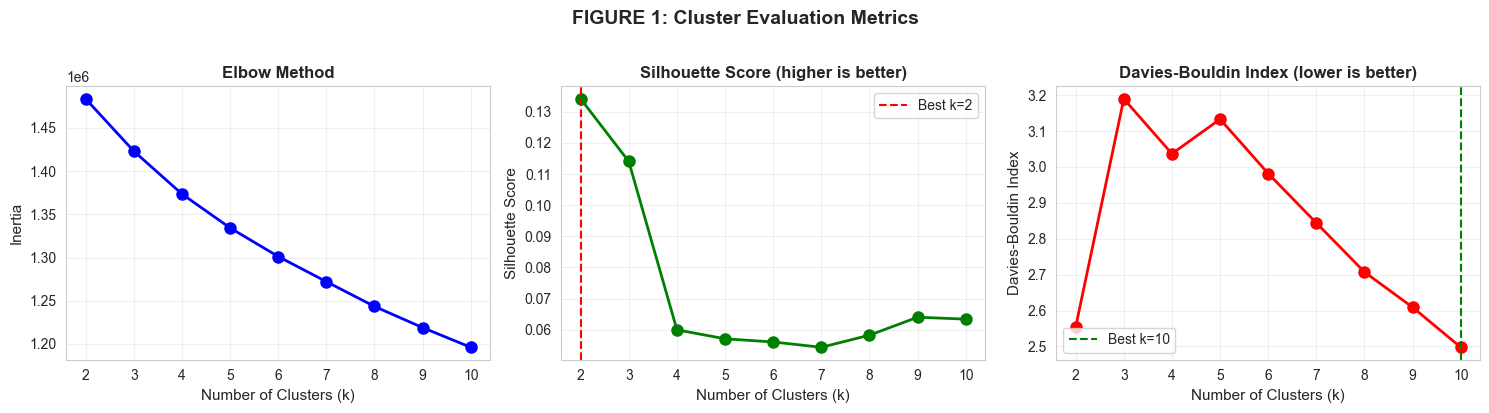


Recommendation:
  • Best k by Silhouette: 2
  • Best k by Davies-Bouldin: 10


In [65]:
# Visualize cluster evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elbow plot
axes[0].plot(results_df['k'], results_df['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Silhouette score (higher is better)
axes[1].plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2, markersize=8)
best_k_silhouette = results_df.loc[results_df['silhouette'].idxmax(), 'k']
axes[1].axvline(x=best_k_silhouette, color='r', linestyle='--', 
                label=f'Best k={best_k_silhouette}')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score (higher is better)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Davies-Bouldin index (lower is better)
axes[2].plot(results_df['k'], results_df['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
best_k_db = results_df.loc[results_df['davies_bouldin'].idxmin(), 'k']
axes[2].axvline(x=best_k_db, color='g', linestyle='--', 
                label=f'Best k={best_k_db}')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[2].set_title('Davies-Bouldin Index (lower is better)', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.suptitle('FIGURE 1: Cluster Evaluation Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\nRecommendation:")
print(f"  • Best k by Silhouette: {best_k_silhouette}")
print(f"  • Best k by Davies-Bouldin: {best_k_db}")

In [66]:
# Select optimal k (use silhouette as primary metric, but cap at reasonable number)
# Also consider interpretability - 4-6 clusters are usually most interpretable

# Find best k in interpretable range (3-7)
interpretable_range = results_df[(results_df['k'] >= 3) & (results_df['k'] <= 7)]
k_optimal = int(interpretable_range.loc[interpretable_range['silhouette'].idxmax(), 'k'])

print(f"\nSelected k = {k_optimal}")
print(f"  Silhouette score: {results_df[results_df['k']==k_optimal]['silhouette'].values[0]:.4f}")
print(f"  Davies-Bouldin: {results_df[results_df['k']==k_optimal]['davies_bouldin'].values[0]:.4f}")


Selected k = 3
  Silhouette score: 0.1140
  Davies-Bouldin: 3.1898


## 4. K-Means Clustering

In [67]:
# Fit final K-Means model

k_optimal = 10 # Overwrite with chosen k
print(f"Fitting K-Means with k={k_optimal} clusters...")
print("="*60)

kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(shap_pca)

# Create analysis DataFrame
cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'y_true': y_val.values,
    'pd_lgbm': y_pred_lgbm,
    'pd_logit': y_pred_logit
}, index=X_val.index)

# Add 2D coordinates for visualization
cluster_df['umap_x'] = shap_2d[:, 0]
cluster_df['umap_y'] = shap_2d[:, 1]

# Cluster size summary
cluster_sizes = cluster_df['cluster'].value_counts().sort_index()
print(f"\nCluster Sizes:")
for c, size in cluster_sizes.items():
    print(f"  Cluster {c}: {size:,} firms ({size/len(cluster_df)*100:.1f}%)")

print(f"\n✓ Clustering complete")

Fitting K-Means with k=10 clusters...

Cluster Sizes:
  Cluster 0: 8,434 firms (13.9%)
  Cluster 1: 13,379 firms (22.0%)
  Cluster 2: 4,534 firms (7.5%)
  Cluster 3: 2,072 firms (3.4%)
  Cluster 4: 5,472 firms (9.0%)
  Cluster 5: 3,285 firms (5.4%)
  Cluster 6: 9,889 firms (16.3%)
  Cluster 7: 6,632 firms (10.9%)
  Cluster 8: 3,066 firms (5.0%)
  Cluster 9: 4,067 firms (6.7%)

✓ Clustering complete


## 5. Cluster Characterization

For each cluster, we analyze:
1. Default rate and predicted PD
2. SHAP value profile (which features drive risk in this cluster)
3. Distinguishing characteristics

In [68]:
# Compute cluster-level statistics
print("="*90)
print("CLUSTER SUMMARY: Default Rates and Predicted Probabilities")
print("="*90)

cluster_summary = cluster_df.groupby('cluster').agg({
    'y_true': ['count', 'sum', 'mean'],
    'pd_lgbm': ['mean', 'median', 'std'],
    'pd_logit': 'mean'
}).round(4)

cluster_summary.columns = ['Size', 'Defaults', 'Default_Rate', 
                           'Mean_PD_LightGBM', 'Median_PD_LightGBM', 'Std_PD_LightGBM',
                           'Mean_PD_Logit']

# Add enrichment ratio (default rate / population default rate)
population_default_rate = y_val.mean()
cluster_summary['Enrichment'] = cluster_summary['Default_Rate'] / population_default_rate

print(cluster_summary.to_string())
print("\n" + "="*90)
print(f"Population default rate: {population_default_rate*100:.2f}%")
print(f"Enrichment = Cluster default rate / Population default rate")
print("  Enrichment > 1: Higher risk than average")
print("  Enrichment < 1: Lower risk than average")

CLUSTER SUMMARY: Default Rates and Predicted Probabilities
          Size  Defaults  Default_Rate  Mean_PD_LightGBM  Median_PD_LightGBM  Std_PD_LightGBM  Mean_PD_Logit  Enrichment
cluster                                                                                                                 
0         8434       152         0.018            0.0170              0.0092           0.0226         0.0223    1.022353
1        13379         7        0.0005            0.0011              0.0008           0.0011         0.0019    0.028399
2         4534         5        0.0011            0.0017              0.0009           0.0025         0.0046    0.062477
3         2072        92        0.0444            0.0418              0.0189           0.0648         0.0320    2.521804
4         5472       539        0.0985            0.0993              0.0685           0.0937         0.0853    5.594542
5         3285         3        0.0009            0.0008              0.0004           0.0014 

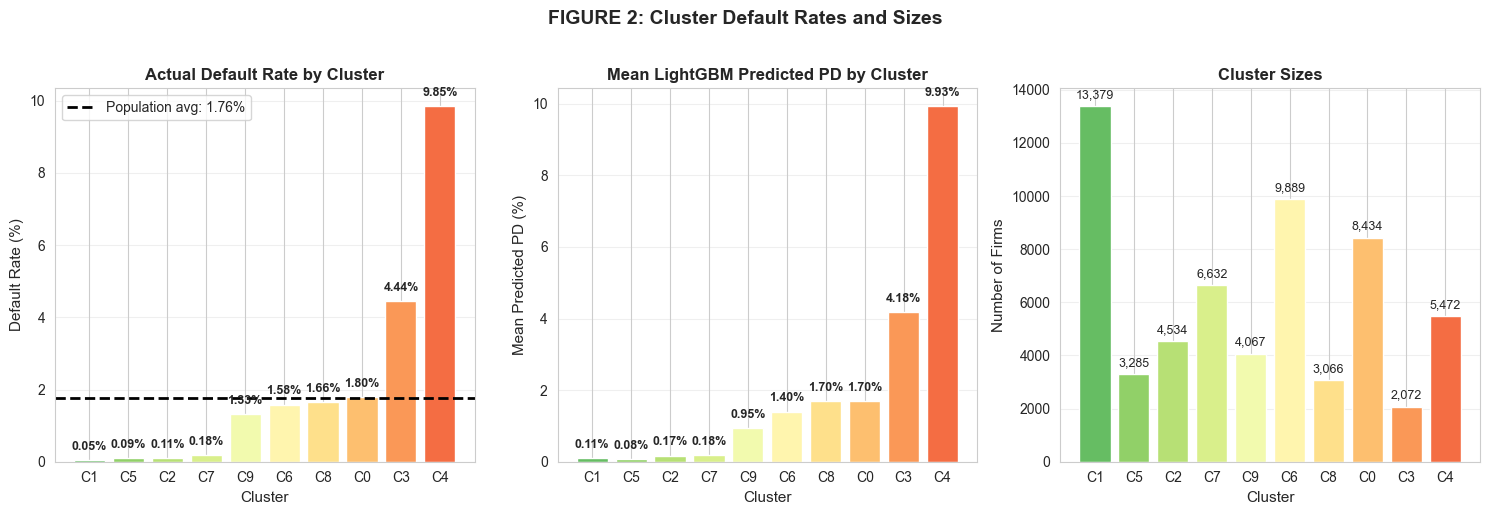

In [69]:
# Visualize default rates by cluster
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sort clusters by default rate for visualization
cluster_order = cluster_summary.sort_values('Default_Rate').index.tolist()

# 1. Default rate bar chart
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, k_optimal))
sorted_rates = cluster_summary.loc[cluster_order, 'Default_Rate']
bars = axes[0].bar(range(k_optimal), sorted_rates * 100, color=colors)
axes[0].axhline(y=population_default_rate*100, color='black', linestyle='--', 
                linewidth=2, label=f'Population avg: {population_default_rate*100:.2f}%')
axes[0].set_xticks(range(k_optimal))
axes[0].set_xticklabels([f'C{c}' for c in cluster_order])
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Default Rate (%)', fontsize=11)
axes[0].set_title('Actual Default Rate by Cluster', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, rate in zip(bars, sorted_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{rate*100:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Mean predicted PD
sorted_pds = cluster_summary.loc[cluster_order, 'Mean_PD_LightGBM']
bars2 = axes[1].bar(range(k_optimal), sorted_pds * 100, color=colors)
axes[1].set_xticks(range(k_optimal))
axes[1].set_xticklabels([f'C{c}' for c in cluster_order])
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Mean Predicted PD (%)', fontsize=11)
axes[1].set_title('Mean LightGBM Predicted PD by Cluster', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for bar, pd in zip(bars2, sorted_pds):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{pd*100:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Cluster sizes
sorted_sizes = cluster_summary.loc[cluster_order, 'Size']
bars3 = axes[2].bar(range(k_optimal), sorted_sizes, color=colors)
axes[2].set_xticks(range(k_optimal))
axes[2].set_xticklabels([f'C{c}' for c in cluster_order])
axes[2].set_xlabel('Cluster', fontsize=11)
axes[2].set_ylabel('Number of Firms', fontsize=11)
axes[2].set_title('Cluster Sizes', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')

for bar, size in zip(bars3, sorted_sizes):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{size:,}', ha='center', va='bottom', fontsize=9)

plt.suptitle('FIGURE 2: Cluster Default Rates and Sizes', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [70]:
# Compute mean SHAP values per cluster
print("Computing SHAP profiles per cluster...")

# Add cluster labels to SHAP values
import pandas as pd  # Re-import to avoid any shadowing issues
shap_df = pd.DataFrame(shap_values_lgbm, columns=feature_names, index=X_val.index)
shap_df['cluster'] = cluster_labels

# Mean SHAP per cluster
cluster_shap_means = shap_df.groupby('cluster')[feature_names].mean()

# Overall mean SHAP (should be ~0)
overall_shap_mean = shap_df[feature_names].mean()

print(f"✓ Computed mean SHAP values for {k_optimal} clusters")
print(f"  Shape: {cluster_shap_means.shape}")

Computing SHAP profiles per cluster...
✓ Computed mean SHAP values for 10 clusters
  Shape: (10, 29)


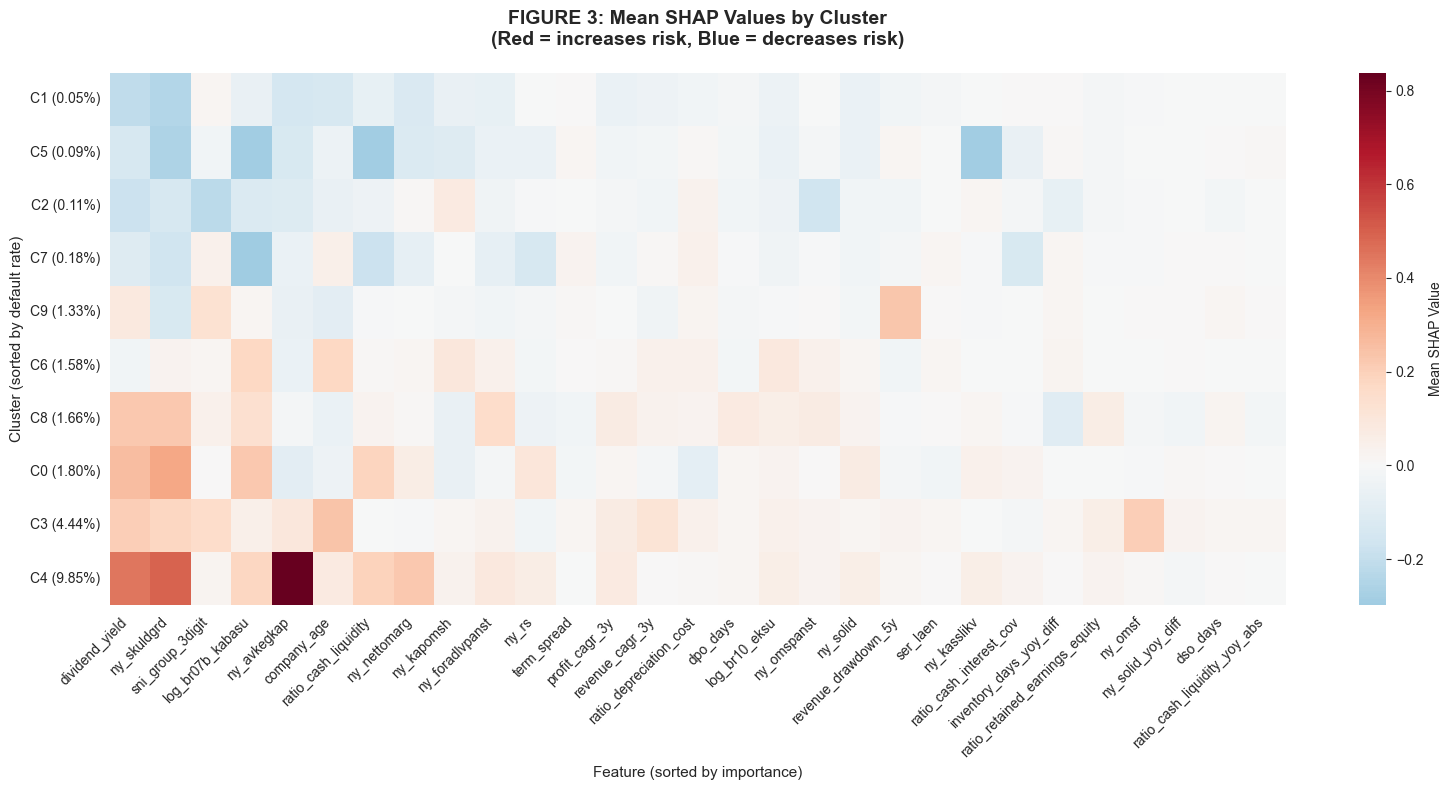

In [71]:
# Heatmap of mean SHAP values per cluster
fig, ax = plt.subplots(figsize=(16, 8))

# Sort features by overall importance (mean absolute SHAP)
feature_importance = np.abs(shap_values_lgbm).mean(axis=0)
sorted_features = [feature_names[i] for i in np.argsort(feature_importance)[::-1]]

# Reorder columns
cluster_shap_sorted = cluster_shap_means[sorted_features]

# Sort rows by default rate
cluster_order_by_risk = cluster_summary.sort_values('Default_Rate').index.tolist()
cluster_shap_sorted = cluster_shap_sorted.loc[cluster_order_by_risk]

# Create heatmap
sns.heatmap(
    cluster_shap_sorted,
    annot=False,
    cmap='RdBu_r',
    center=0,
    ax=ax,
    cbar_kws={'label': 'Mean SHAP Value'}
)

# Add default rate annotation to y-axis
ytick_labels = [f"C{c} ({cluster_summary.loc[c, 'Default_Rate']*100:.2f}%)" 
                for c in cluster_order_by_risk]
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_xlabel('Feature (sorted by importance)', fontsize=11)
ax.set_ylabel('Cluster (sorted by default rate)', fontsize=11)
ax.set_title('FIGURE 3: Mean SHAP Values by Cluster\n(Red = increases risk, Blue = decreases risk)',
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [72]:
# Identify top distinguishing features for each cluster
print("="*90)
print("TOP DISTINGUISHING FEATURES PER CLUSTER")
print("="*90)

for cluster_id in cluster_order_by_risk:
    cluster_shap = cluster_shap_means.loc[cluster_id]
    
    # Features with highest positive SHAP (increase risk)
    top_positive = cluster_shap.nlargest(3)
    
    # Features with most negative SHAP (decrease risk)
    top_negative = cluster_shap.nsmallest(3)
    
    default_rate = cluster_summary.loc[cluster_id, 'Default_Rate']
    enrichment = cluster_summary.loc[cluster_id, 'Enrichment']
    size = cluster_summary.loc[cluster_id, 'Size']
    
    print(f"\n{'─'*90}")
    print(f"Cluster {cluster_id}: {size:,} firms | Default Rate: {default_rate*100:.2f}% | Enrichment: {enrichment:.2f}x")
    print(f"{'─'*90}")
    
    print(f"\n  Risk-INCREASING features (positive SHAP):")
    for feat, val in top_positive.items():
        print(f"    • {feat}: {val:+.3f}")
    
    print(f"\n  Risk-DECREASING features (negative SHAP):")
    for feat, val in top_negative.items():
        print(f"    • {feat}: {val:+.3f}")

print("\n" + "="*90)

TOP DISTINGUISHING FEATURES PER CLUSTER

──────────────────────────────────────────────────────────────────────────────────────────
Cluster 1: 13,379 firms | Default Rate: 0.05% | Enrichment: 0.03x
──────────────────────────────────────────────────────────────────────────────────────────

  Risk-INCREASING features (positive SHAP):
    • sni_group_3digit: +0.019
    • inventory_days_yoy_diff: +0.007
    • term_spread: +0.006

  Risk-DECREASING features (negative SHAP):
    • ny_skuldgrd: -0.243
    • dividend_yield: -0.214
    • ny_avkegkap: -0.145

──────────────────────────────────────────────────────────────────────────────────────────
Cluster 5: 3,285 firms | Default Rate: 0.09% | Enrichment: 0.05x
──────────────────────────────────────────────────────────────────────────────────────────

  Risk-INCREASING features (positive SHAP):
    • term_spread: +0.018
    • revenue_drawdown_5y: +0.013
    • ratio_depreciation_cost: +0.010

  Risk-DECREASING features (negative SHAP):
    • log

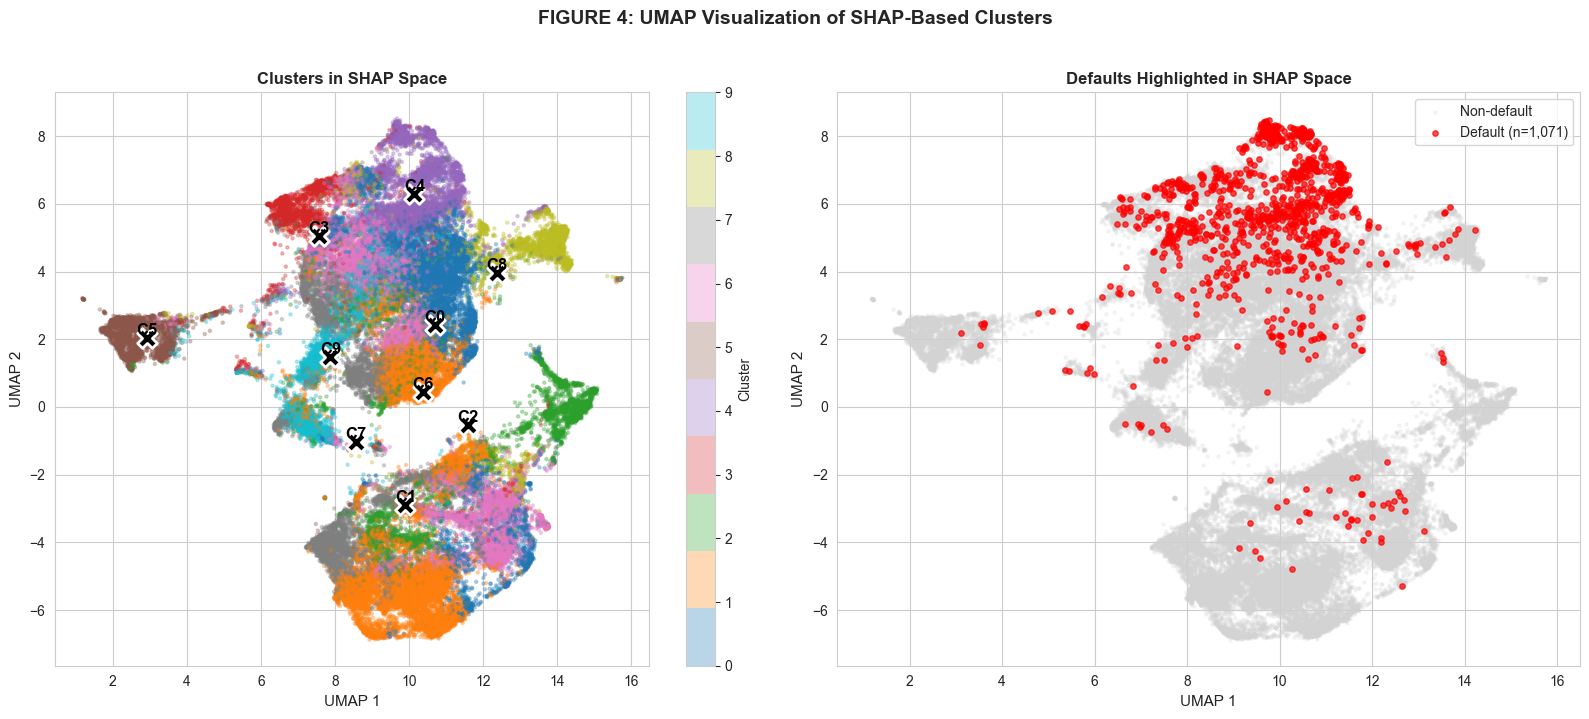


Note: Defaults (red) should cluster in high-risk regions if clustering is effective.


In [73]:
# UMAP visualization with clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Color by cluster
scatter1 = axes[0].scatter(
    cluster_df['umap_x'], 
    cluster_df['umap_y'],
    c=cluster_df['cluster'],
    cmap='tab10',
    alpha=0.3,
    s=5
)

# Add cluster centers (mean of 2D coordinates)
for c in range(k_optimal):
    mask = cluster_df['cluster'] == c
    cx = cluster_df.loc[mask, 'umap_x'].mean()
    cy = cluster_df.loc[mask, 'umap_y'].mean()
    axes[0].scatter([cx], [cy], c='black', s=200, marker='X', edgecolors='white', linewidths=2)
    axes[0].annotate(f'C{c}', (cx, cy), fontsize=12, fontweight='bold', 
                     ha='center', va='bottom', color='black')

axes[0].set_xlabel('UMAP 1', fontsize=11)
axes[0].set_ylabel('UMAP 2', fontsize=11)
axes[0].set_title('Clusters in SHAP Space', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster')

# 2. Highlight defaults
# Plot non-defaults first (gray)
non_defaults = cluster_df[cluster_df['y_true'] == 0]
axes[1].scatter(
    non_defaults['umap_x'],
    non_defaults['umap_y'],
    c='lightgray',
    alpha=0.2,
    s=5,
    label='Non-default'
)

# Plot defaults on top (red) 
defaults = cluster_df[cluster_df['y_true'] == 1]
axes[1].scatter(
    defaults['umap_x'],
    defaults['umap_y'],
    c='red',
    alpha=0.7,
    s=15,
    label=f'Default (n={len(defaults):,})'
)

axes[1].set_xlabel('UMAP 1', fontsize=11)
axes[1].set_ylabel('UMAP 2', fontsize=11)
axes[1].set_title('Defaults Highlighted in SHAP Space', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')

plt.suptitle('FIGURE 4: UMAP Visualization of SHAP-Based Clusters', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nNote: Defaults (red) should cluster in high-risk regions if clustering is effective.")

## 6. Cluster Deep Dive: PD Distributions

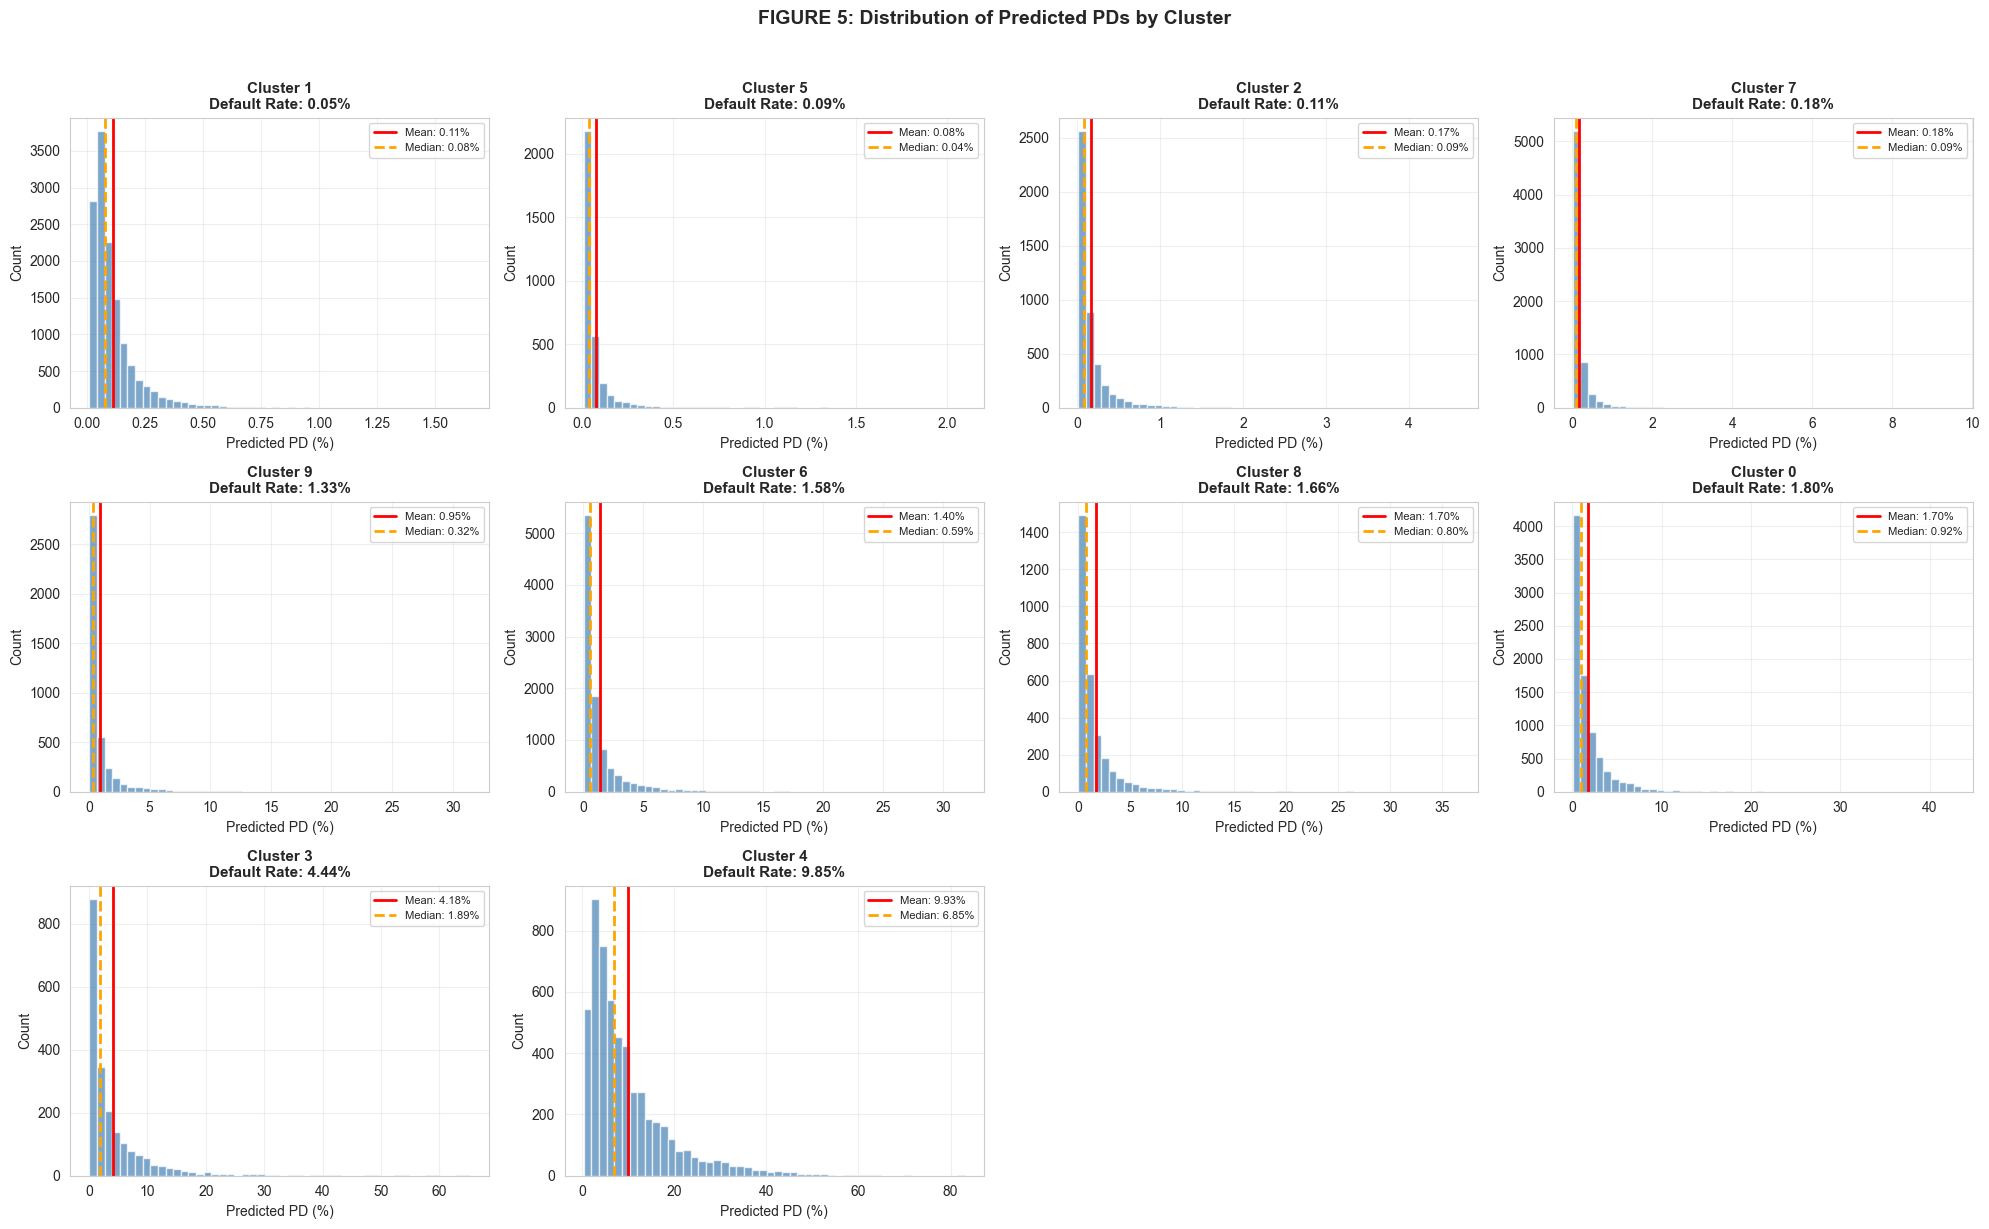

In [74]:
# Distribution of predicted PDs within each cluster
n_cols = min(k_optimal, 4)
n_rows = (k_optimal + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if k_optimal > 1 else [axes]

for i, cluster_id in enumerate(cluster_order_by_risk):
    ax = axes[i]
    cluster_data = cluster_df[cluster_df['cluster'] == cluster_id]
    
    # Histogram of PDs
    ax.hist(cluster_data['pd_lgbm'] * 100, bins=50, color='steelblue', 
            alpha=0.7, edgecolor='white')
    
    # Add vertical lines for mean and median
    mean_pd = cluster_data['pd_lgbm'].mean() * 100
    median_pd = cluster_data['pd_lgbm'].median() * 100
    ax.axvline(x=mean_pd, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_pd:.2f}%')
    ax.axvline(x=median_pd, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_pd:.2f}%')
    
    default_rate = cluster_summary.loc[cluster_id, 'Default_Rate'] * 100
    ax.set_xlabel('Predicted PD (%)', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'Cluster {cluster_id}\nDefault Rate: {default_rate:.2f}%', 
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('FIGURE 5: Distribution of Predicted PDs by Cluster', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7. Assign Descriptive Names to Clusters

In [75]:
# Create a summary table with interpretable names
# Based on default rates and SHAP profiles

def assign_cluster_name(cluster_id, cluster_summary, cluster_shap_means):
    """Assign descriptive name based on characteristics"""
    default_rate = cluster_summary.loc[cluster_id, 'Default_Rate']
    enrichment = cluster_summary.loc[cluster_id, 'Enrichment']
    
    # Get top features
    top_pos = cluster_shap_means.loc[cluster_id].nlargest(2).index.tolist()
    top_neg = cluster_shap_means.loc[cluster_id].nsmallest(2).index.tolist()
    
    # Assign risk category
    if enrichment >= 3:
        risk_level = "High Risk"
    elif enrichment >= 1.5:
        risk_level = "Elevated Risk"
    elif enrichment >= 0.7:
        risk_level = "Moderate Risk"
    elif enrichment >= 0.3:
        risk_level = "Low Risk"
    else:
        risk_level = "Very Low Risk"
    
    return {
        'cluster': cluster_id,
        'risk_level': risk_level,
        'enrichment': enrichment,
        'default_rate_pct': default_rate * 100,
        'size': cluster_summary.loc[cluster_id, 'Size'],
        'top_risk_features': ', '.join(top_pos[:2]),
        'top_protective_features': ', '.join(top_neg[:2])
    }

cluster_profiles = [assign_cluster_name(c, cluster_summary, cluster_shap_means) 
                    for c in range(k_optimal)]
cluster_profiles_df = pd.DataFrame(cluster_profiles)
cluster_profiles_df = cluster_profiles_df.sort_values('default_rate_pct', ascending=False)

print("="*100)
print("FINAL CLUSTER ARCHETYPES")
print("="*100)
print(cluster_profiles_df.to_string(index=False))
print("="*100)

FINAL CLUSTER ARCHETYPES
 cluster    risk_level  enrichment  default_rate_pct  size                         top_risk_features                         top_protective_features
       4     High Risk    5.594542              9.85  5472                  ny_avkegkap, ny_skuldgrd ny_solid_yoy_diff, ratio_cash_liquidity_yoy_abs
       3 Elevated Risk    2.521804              4.44  2072                      company_age, ny_omsf                  ny_rs, ratio_cash_interest_cov
       0 Moderate Risk    1.022353              1.80  8434               ny_skuldgrd, dividend_yield            ny_avkegkap, ratio_depreciation_cost
       8 Moderate Risk    0.942837              1.66  3066               ny_skuldgrd, dividend_yield             inventory_days_yoy_diff, ny_kapomsh
       6 Moderate Risk    0.897399              1.58  9889             log_br07b_kabasu, company_age                     ny_avkegkap, dividend_yield
       9 Moderate Risk    0.755405              1.33  4067     revenue_drawdown_5

## 8. Summary & Key Findings

In [76]:
# Final summary
print("="*90)
print("SUMMARY: SHAP-Based Clustering Analysis")
print("="*90)

# Check success criteria
max_default_rate = cluster_summary['Default_Rate'].max()
min_default_rate = cluster_summary['Default_Rate'].min()
max_enrichment = cluster_summary['Enrichment'].max()
min_enrichment = cluster_summary['Enrichment'].min()

print(f"\n1. CLUSTERING RESULTS:")
print(f"   • Number of clusters: {k_optimal}")
print(f"   • Silhouette score: {results_df[results_df['k']==k_optimal]['silhouette'].values[0]:.4f}")
print(f"   • Dimensionality: {shap_scaled.shape[1]} → {shap_pca.shape[1]} (PCA)")

print(f"\n2. DEFAULT RATE VARIATION:")
print(f"   • Population default rate: {population_default_rate*100:.2f}%")
print(f"   • Lowest cluster: {min_default_rate*100:.2f}% (Enrichment: {min_enrichment:.2f}x)")
print(f"   • Highest cluster: {max_default_rate*100:.2f}% (Enrichment: {max_enrichment:.2f}x)")
print(f"   • Spread: {(max_default_rate - min_default_rate)*100:.2f} percentage points")

print(f"\n3. SUCCESS CRITERIA CHECK:")
criteria_1 = max_default_rate > 0.05  # High-risk cluster > 5%
criteria_2 = min_default_rate < 0.01  # Low-risk cluster < 1%
criteria_3 = max_enrichment > 2       # High-risk at least 2x enriched

print(f"   ✓ High-risk cluster > 5% default rate: {'YES' if criteria_1 else 'NO'} ({max_default_rate*100:.2f}%)")
print(f"   ✓ Low-risk cluster < 1% default rate: {'YES' if criteria_2 else 'NO'} ({min_default_rate*100:.2f}%)")
print(f"   ✓ Enrichment ratio > 2x: {'YES' if criteria_3 else 'NO'} ({max_enrichment:.2f}x)")

if criteria_1 and criteria_2 and criteria_3:
    print(f"\n→ CONCLUSION: Clustering reveals MEANINGFUL prediction archetypes.")
    print(f"  The model distinguishes firms into groups with substantially different risk profiles.")
elif criteria_1 or criteria_3:
    print(f"\n→ CONCLUSION: Clustering reveals MODERATE differentiation.")
    print(f"  Some clusters are enriched for defaults, but the pattern is not dramatic.")
else:
    print(f"\n→ CONCLUSION: Clustering does NOT reveal discrete archetypes.")
    print(f"  The model uses a continuous risk spectrum rather than distinct groups.")

print("\n" + "="*90)

SUMMARY: SHAP-Based Clustering Analysis

1. CLUSTERING RESULTS:
   • Number of clusters: 10
   • Silhouette score: 0.0634
   • Dimensionality: 29 → 25 (PCA)

2. DEFAULT RATE VARIATION:
   • Population default rate: 1.76%
   • Lowest cluster: 0.05% (Enrichment: 0.03x)
   • Highest cluster: 9.85% (Enrichment: 5.59x)
   • Spread: 9.80 percentage points

3. SUCCESS CRITERIA CHECK:
   ✓ High-risk cluster > 5% default rate: YES (9.85%)
   ✓ Low-risk cluster < 1% default rate: YES (0.05%)
   ✓ Enrichment ratio > 2x: YES (5.59x)

→ CONCLUSION: Clustering reveals MEANINGFUL prediction archetypes.
  The model distinguishes firms into groups with substantially different risk profiles.



In [77]:
# Save results
results_dir = PROJ_ROOT / "results" / "xai_clustering"
results_dir.mkdir(parents=True, exist_ok=True)

# Save cluster assignments
cluster_df.to_csv(results_dir / "cluster_assignments.csv")

# Save cluster summary
cluster_summary.to_csv(results_dir / "cluster_summary.csv")

# Save cluster SHAP profiles
cluster_shap_means.to_csv(results_dir / "cluster_shap_profiles.csv")

# Save cluster archetypes
cluster_profiles_df.to_csv(results_dir / "cluster_archetypes.csv", index=False)

print(f"✓ Results saved to: {results_dir}")
print(f"  • cluster_assignments.csv ({len(cluster_df):,} rows)")
print(f"  • cluster_summary.csv")
print(f"  • cluster_shap_profiles.csv")
print(f"  • cluster_archetypes.csv")

✓ Results saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/xai_clustering
  • cluster_assignments.csv (60,830 rows)
  • cluster_summary.csv
  • cluster_shap_profiles.csv
  • cluster_archetypes.csv
